In this notebook, we follow the Generative Adversarial Imputation Net (GAIN) method of (Yoon, 2018)

In [87]:
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader

from utils import generate_B, count_parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 256   # batch_size
p_miss = 0.2       # Missing rate
p_hint = 0.9       # Hint rate
alpha = 10         # Hyperparameter (forces nonmissings to be imputed as original value)
train_rate = 0.8   # ??

,Cat 1,Cat 2,Cat 3,Cat 4,Cat 5,Cat 6
0,2,8,3,5,1,8
1,5,12,3,7,2,10
2,4,11,6,8,6,10
3,7,11,6,6,3,5
4,2,1,3,1,1,8
...,...,...,...,...,...,...
19995,2,2,3,3,2,7
19996,7,10,8,8,4,4
19997,6,9,6,7,5,6
19998,2,3,4,2,1,8


We load the data. In this test case, we use the spam.csv from the original author of GAIN. One would expect that columns that are less correlated with other columns, show less accurate imputed reconstructions

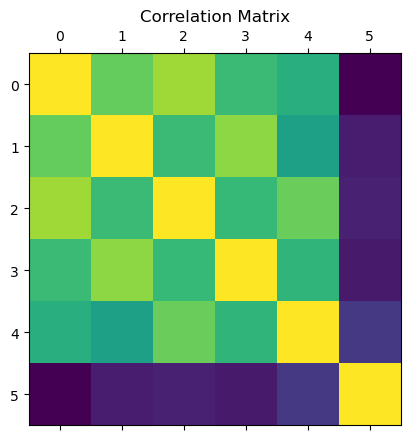

In [106]:
# data = load_iris().data
# data = torch.from_numpy(data).float()

data_pandas = pd.read_csv("./data/letter.csv")
data_pandas = data_pandas.iloc[:, 0:6]

data_numpy = data_pandas.to_numpy()
data = torch.tensor(data_numpy)

data_length, data_dim = data.shape

plt.matshow(data_pandas.corr())
plt.title('Correlation Matrix')
plt.show()

Masking the letter data set with a determines missing rate. Note that these are NOT part of the general parameters as they are only used to synthesize missingness

In [107]:
placeholder_value = -1e6
prob_missing = 0.2

missings = (torch.rand(data.shape) < prob_missing)

data_masked = data.clone()
data_masked[missings] = placeholder_value

train_loader = DataLoader(data_masked, batch_size=batch_size, shuffle=True)

At first, we mimick the (simple) architecture of (Yoon, 2014).

In [108]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2*data_dim, data_dim),
            nn.ReLU(),
            nn.Linear(data_dim, data_dim),
            nn.ReLU(),
            nn.Linear(data_dim, data_dim),
            nn.ReLU(),
            nn.Sigmoid()
        )
    
    def forward(self, x, hinting):
        data_cat = torch.cat([x, hinting], axis=1)
        return self.network(data_cat)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2*data_dim, data_dim),
            nn.ReLU(),
            nn.Linear(data_dim, data_dim),
            nn.ReLU(),
            nn.Linear(data_dim, data_dim),
            nn.ReLU()#,
            #nn.Sigmoid() # This is only valid when you first apply a MinMaxScaler
        )

    def forward(self, x, missing):
        data_cat = torch.cat([x, missing], axis=1)
        return self.network(data_cat)

In [109]:
generate = Generator().to(device)
discriminate = Discriminator().to(device)

lr_discriminator = 2e-4
lr_generator = 4e-4

optimizer_generator = optim.Adam(generate.parameters(), lr=lr_generator, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminate.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))

lossfunction = nn.BCELoss()
loss_fn = nn.BCELoss(reduction='none')

count_parameters(discriminate), count_parameters(generate)

(162, 162)

In [113]:
epochs = 5000

discriminate_loss, generate_loss = [], []
total_batches = len(train_loader)

for epoch in range(epochs):
    start_time = time.time()
    running_loss_disc = 0.0
    running_loss_gen = 0.0

    # Updating the Generator in batches
    for batch in train_loader:
        ### Update discriminator
        optimizer_discriminator.zero_grad()

        B = generate_B(*batch.shape).detach()
        Z = 1*torch.rand(batch.shape) # resembles Z in the paper Unif(0, 1)
        M = 1-torch.eq(batch, placeholder_value).float()
        H = B*M + .5*(1-B)
        
        batch_noised = batch*M + Z*(1-M)
        batch_generated = generate(batch_noised, M).detach()
        batch_imputed = M*batch + (1-M)*batch_generated # (equation 3) 
        batch_discriminated = discriminate(batch_imputed, H) # hier stond eerst H ipv M..


        # BCEloss: L(x, y) = y*log(x) + (1-y)*log(1-x)
        # So we want to use 

        # bce_loss_disc = loss_fn(batch_discriminated, H)
        loss_discriminator = -torch.mean(M * torch.log(batch_discriminated + 1e-8) + (1-M) * torch.log(1. - batch_discriminated + 1e-8))

        # loss_discriminator = -(1-B)*M*torch.log(batch_discriminated+1e-8) - (1-B)*(1-M)*torch.log(1-batch_discriminated+1e-8)
        # loss_discriminator = -lossfunction(batch_discriminated+1e-8, H)  # (16) shows that we only sum for b_i=0! WRONGGGGG

        loss_discriminator.backward()
        optimizer_discriminator.step()
        running_loss_disc += loss_discriminator.item()

        ### Update generator
        optimizer_generator.zero_grad()
        
        B = generate_B(*batch.shape) 
        Z = 1*torch.rand(batch.shape) # resembles Z in the paper Unif(0, 1)
        M = 1-torch.eq(batch, placeholder_value).float()
        H = B*M + .5*(1-B)

        batch_noised = batch*M + Z*(1-M)
        batch_generated = generate(batch_noised, M)
        batch_imputed = M*batch + (1-M)*batch_generated # (equation 3) 
        batch_discriminated = discriminate(batch_imputed, H) # hier stond eerst H ipv M..
        
        # 
        loss_generator_pt1 = -torch.mean((1-M) * torch.log(batch_discriminated + 1e-8))
        MSE_train_loss = torch.mean( (M*(batch - batch_generated))**2) / torch.mean(M) # This makes sure that the non-missing values (M=1) are forces to equal values

        loss_generator = loss_generator_pt1 + alpha * MSE_train_loss 

        running_loss_gen += loss_generator.item()

        loss_generator.backward()
        optimizer_generator.step()

    avg_loss_disc = running_loss_disc / (K * total_batches)
    avg_loss_gen = running_loss_gen / total_batches

    discriminate_loss.append(avg_loss_disc)
    generate_loss.append(avg_loss_gen)
    
    # Display the epoch progress
    progress = (epoch + 1) / epochs * 100
    print(f"Epoch [{epoch + 1}/{epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f} | "
          f"Time: {time.time() - start_time:.2f}s")
        

Epoch [1/5000] - 0.02% complete | Discriminator Loss: 0.3581 | Generator Loss: 193.8209 | Time: 0.42s
Epoch [2/5000] - 0.04% complete | Discriminator Loss: 0.3560 | Generator Loss: 193.8014 | Time: 0.45s
Epoch [3/5000] - 0.06% complete | Discriminator Loss: 0.3533 | Generator Loss: 193.0130 | Time: 0.40s
Epoch [4/5000] - 0.08% complete | Discriminator Loss: 0.3507 | Generator Loss: 193.3164 | Time: 0.44s
Epoch [5/5000] - 0.10% complete | Discriminator Loss: 0.3483 | Generator Loss: 193.0175 | Time: 0.43s
Epoch [6/5000] - 0.12% complete | Discriminator Loss: 0.3462 | Generator Loss: 193.1357 | Time: 0.39s
Epoch [7/5000] - 0.14% complete | Discriminator Loss: 0.3449 | Generator Loss: 192.6462 | Time: 0.39s
Epoch [8/5000] - 0.16% complete | Discriminator Loss: 0.3430 | Generator Loss: 192.9101 | Time: 0.46s
Epoch [9/5000] - 0.18% complete | Discriminator Loss: 0.3431 | Generator Loss: 178.4550 | Time: 0.41s
Epoch [10/5000] - 0.20% complete | Discriminator Loss: 0.3566 | Generator Loss: 10

KeyboardInterrupt: 

In [114]:
B = generate_B(*data.shape).detach()
Z = 1*torch.rand(data.shape) # resembles Z in the paper Unif(0, 1)
M = 1-torch.eq(data_masked, placeholder_value).float()
H = B*M + .5*(1-B)
        
batch_noised = data*M + Z*(1-M)
batch_generated = generate(batch_noised, M).detach()
batch_imputed = data_masked*M + batch_generated*(1-M)

batch_imputed[7:8], data[7:8]

(tensor([[1., 1., 3., 2., 1., 8.]]), tensor([[1, 1, 3, 2, 1, 8]]))

The following function checks how well the column is imputed. We also want to see if there is a link with the original correlation

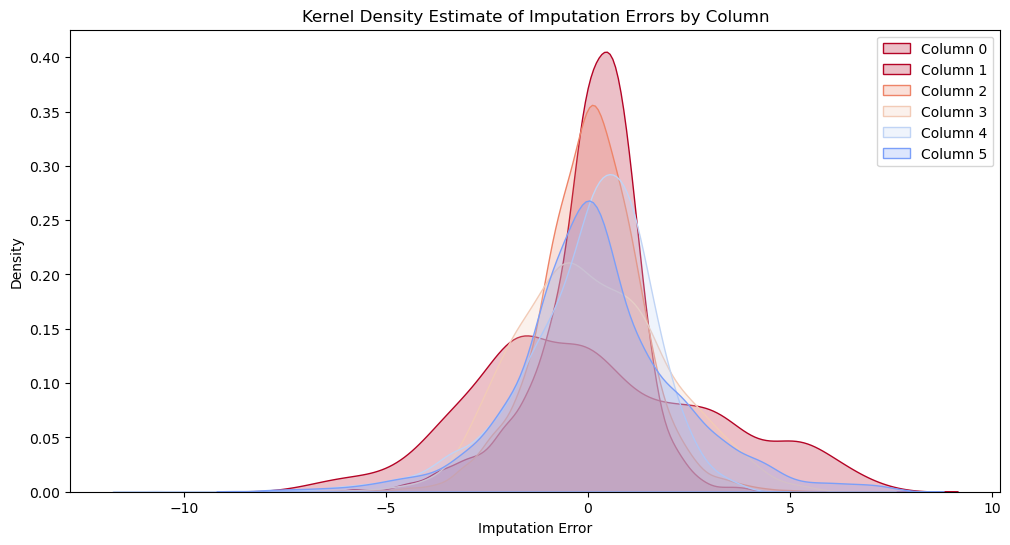

In [115]:
errors = (batch_imputed - data) * (1 - M)
errors_np = errors.numpy()

plt.figure(figsize=(12, 6))

cmap = plt.get_cmap('coolwarm') 
num_columns = errors_np.shape[1]
for i in range(num_columns):
    column_errors = errors_np[:, i]
    non_zero_errors = column_errors[column_errors != 0]
    color = cmap((num_columns-i) / (num_columns - 1))
    sns.kdeplot(non_zero_errors, label=f'Column {i}', fill=True, color=color)

plt.xlabel('Imputation Error')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Imputation Errors by Column')
plt.legend()
plt.show()